In [ ]:
# Configuration - change these to analyze different periods
ANALYSIS_YEAR = 2022
ANALYSIS_MONTH = 7

# Date range for detailed temperature analysis
DETAIL_START_DATE = '2022-07-03'
DETAIL_END_DATE = '2022-07-10'

# Site to analyze in detail (3707 = RMB Chivenor)
DETAIL_SITE_ID = '3707'
DETAIL_SITE_NAME = 'RMB Chivenor'

# Broken sensor to exclude from analysis
EXCLUDE_SITE = 'CHIVENOR'

# Month names for display
MONTH_NAMES = {
    1: "January", 2: "February", 3: "March", 4: "April",
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

print(f"Analysis Period: {MONTH_NAMES[ANALYSIS_MONTH]} {ANALYSIS_YEAR}")
print(f"Detail Period: {DETAIL_START_DATE} to {DETAIL_END_DATE}")
print(f"Excluding site: {EXCLUDE_SITE}")

# Min and Max Temperatures

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, "..")
from helpers.aws import execute_athena_query

sns.set_theme()

sql = f"""
select
  min(temperature) as min_temp,
  max(temperature) as max_temp,
  avg(temperature) as mean_temp,
  month
from (
        select
            temperature,
            date_trunc('month', observation_ts) as month
        from incoming.weather
        where year <> '{ANALYSIS_YEAR}' and month <> '{ANALYSIS_MONTH}' and site_name <> '{EXCLUDE_SITE}' or temperature > -5 -- exclude broken readings
    )
group by month
order by month
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
df = pd.read_csv(results_url)
df['month'] = pd.to_datetime(df['month']).dt.strftime('%B %Y')
df["mean_temp"] = df["mean_temp"].round(1)
df

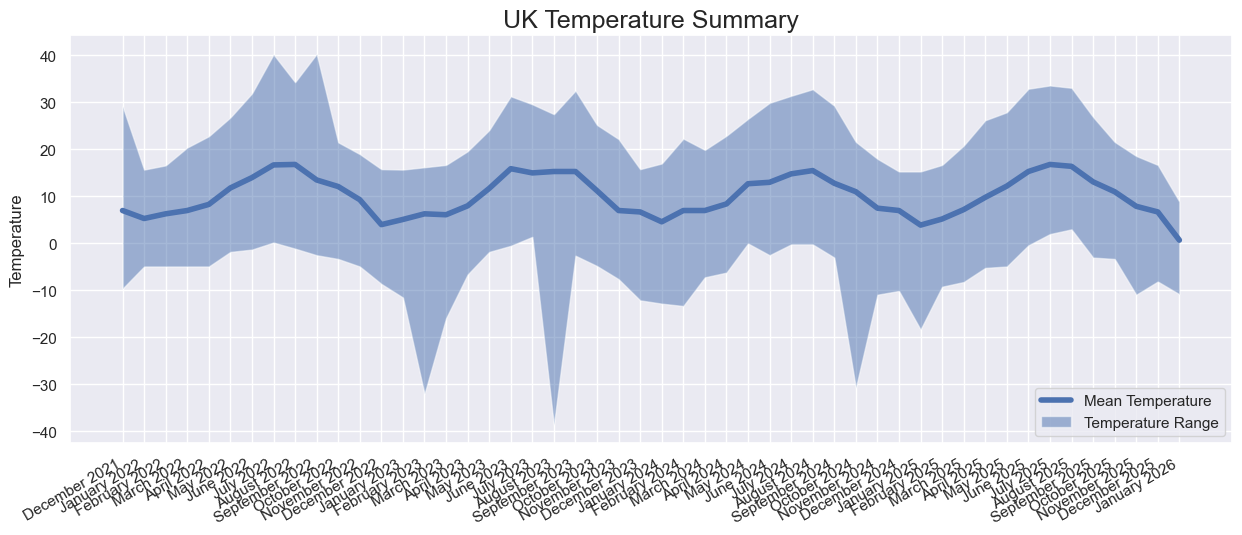

In [85]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_title('UK Temperature Summary', fontdict={'fontsize': '18', 'fontweight' : '3'})

# Ensure numeric types for plotting
df['min_temp'] = pd.to_numeric(df['min_temp'], errors='coerce')
df['max_temp'] = pd.to_numeric(df['max_temp'], errors='coerce')
df['mean_temp'] = pd.to_numeric(df['mean_temp'], errors='coerce')

ax.plot(df.index, df['mean_temp'], linewidth=4.0, label="Mean Temperature")
ax.fill_between(df.index, df['min_temp'], df['max_temp'], alpha=0.5, label="Temperature Range")

plt.gcf().autofmt_xdate()

plt.xlabel('')
plt.ylabel('Temperature', fontsize=12)
plt.legend(loc='lower right')
plt.xticks(df.index, df["month"].values)
plt.show()

In [ ]:
sql = f"""
select site_id, site_name, observation_ts, temperature, lat, lon 
from incoming.weather 
where year = '{ANALYSIS_YEAR}' and month = '{ANALYSIS_MONTH}' 
order by temperature asc 
limit 3
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
cold_places = pd.read_csv(results_url)
cold_places

In [ ]:
sql = f"""
select observation_ts, temperature 
from incoming.weather 
where year = '{ANALYSIS_YEAR}' and month = '{ANALYSIS_MONTH}'
  and observation_ts between TIMESTAMP '{DETAIL_START_DATE} 00:00:00' and TIMESTAMP '{DETAIL_END_DATE} 00:00:00' 
  and site_id = '{DETAIL_SITE_ID}' 
order by observation_ts asc
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
detail_data = pd.read_csv(results_url)

detail_data['xlabel'] = pd.to_datetime(detail_data['observation_ts']).dt.strftime('%d %B %H:%m')

f, ax = plt.subplots(figsize=(15, 6))
ax.set_title(f'{DETAIL_SITE_NAME}, {MONTH_NAMES[ANALYSIS_MONTH]} Temperatures', fontdict={'fontsize': '18', 'fontweight' : '3'})

ax.plot(detail_data.index, detail_data.temperature, linewidth=4.0, label="Temperature")

plt.gcf().autofmt_xdate()

plt.xlabel('')
plt.ylabel('Temperature', fontsize=12)
plt.legend(loc='lower right')
plt.xticks(detail_data.index, detail_data["xlabel"].values)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(6))
plt.show()

# Finding Duplciates

## Duplicates by Partition

In [88]:
sql = f"""
select
  count(*) as num_rows,
  cast(year as int) as year,
  cast(month as int) as month
from incoming.weather
group by year, month
order by num_rows desc
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
df1 = pd.read_csv(results_url)

df1.head(10)


,num_rows,year,month
0,107736,2022,1
1,106865,2022,3
2,106071,2022,5
3,104945,2023,3
4,104765,2022,7
5,104604,2024,3
6,104576,2022,8
7,104456,2023,10
8,104251,2022,10
9,104206,2024,5


## Duplicates by Event Time

In [89]:

sql = f"""
select
    obs_period,
    count(*) as num_rows from
    (
        select
          *,
          date_trunc('day', observation_ts) as obs_period
          from incoming.weather
    )
group by obs_period
order by num_rows desc
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
df2 = pd.read_csv(results_url)
df2.head(10)

,obs_period,num_rows
0,2021-12-13 00:00:00.000,6199
1,2025-08-20 00:00:00.000,5320
2,2022-01-05 00:00:00.000,5278
3,2022-10-19 00:00:00.000,4839
4,2022-11-26 00:00:00.000,3664
5,2022-01-21 00:00:00.000,3500
6,2022-01-15 00:00:00.000,3499
7,2022-01-20 00:00:00.000,3499
8,2022-01-13 00:00:00.000,3499
9,2022-01-11 00:00:00.000,3499


## Distribution of row counts

Clearly most days have the 'right' number of rows, but there are a few outliers with too many or too few.

See below cumulative distribution (ECFD) and Kernel density estimation (KDE) for the number of rows vs days.

<Axes: title={'center': 'ECFD Plot'}, xlabel='num_rows', ylabel='Proportion'>

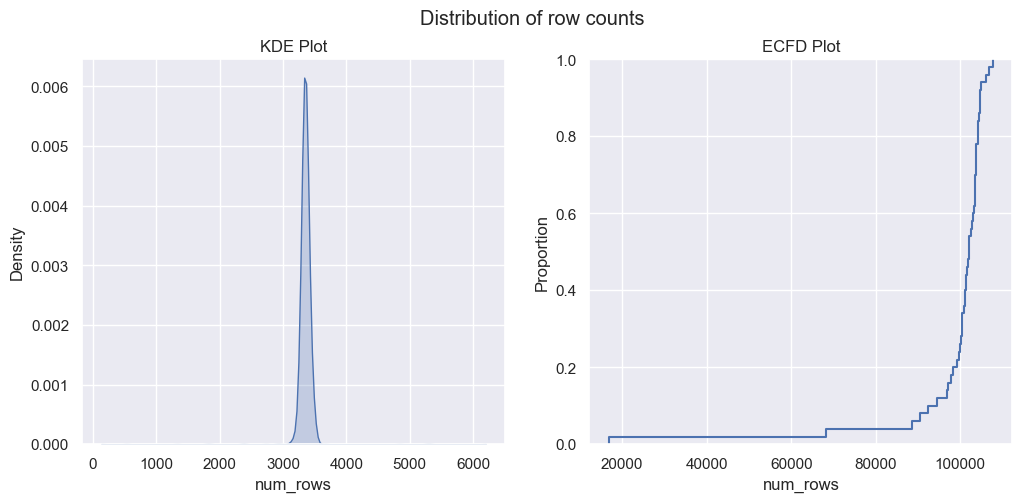

In [90]:
figure, axes = plt.subplots(1, 2, figsize=(12,5))
figure.suptitle('Distribution of row counts')
axes[0].set_title('KDE Plot')
axes[1].set_title('ECFD Plot')

sns.kdeplot(df2, ax=axes[0], x="num_rows", cut=0, fill=True)
sns.ecdfplot(df1, ax=axes[1], x="num_rows")

## Deduplication

In [91]:
sql = f"""
select
    obs_period,
    count(*) as num_rows
from
(
    select
        *,
        date_trunc('day', observation_ts) as obs_period,
        ROW_NUMBER() OVER ( partition by date_trunc('hour', observation_ts), site_id order by observation_ts desc ) as rn
       from incoming.weather
)
where rn = 1
group by obs_period
order by num_rows desc
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
deduped_df = pd.read_csv(results_url)
deduped_df.head(5)

,obs_period,num_rows
0,2022-01-15 00:00:00.000,3360
1,2022-01-21 00:00:00.000,3360
2,2022-01-11 00:00:00.000,3360
3,2022-01-13 00:00:00.000,3359
4,2022-01-20 00:00:00.000,3359


<Axes: title={'center': 'ECFD Plot'}, xlabel='num_rows', ylabel='Proportion'>

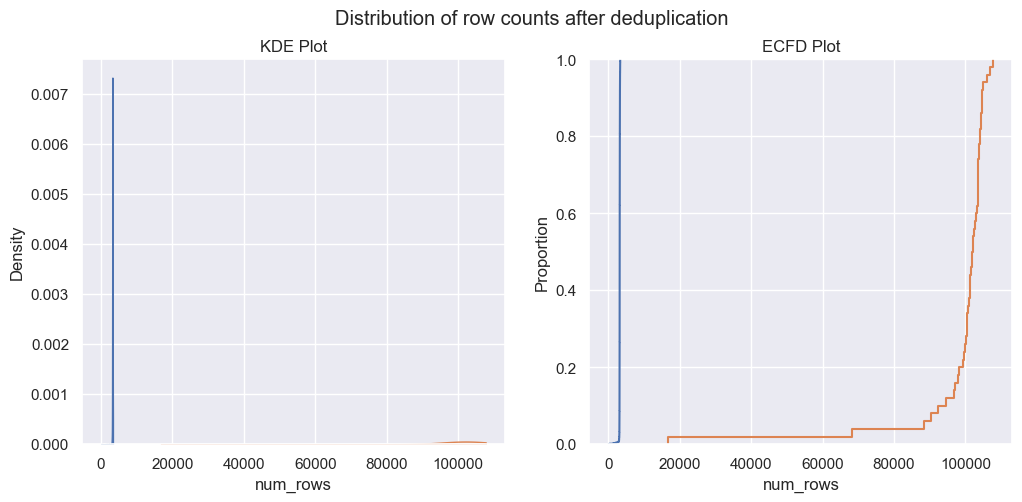

In [92]:
figure, axes = plt.subplots(1, 2, figsize=(12,5))
figure.suptitle('Distribution of row counts after deduplication')
axes[0].set_title('KDE Plot')
axes[1].set_title('ECFD Plot')

sns.kdeplot(deduped_df, ax=axes[0], x="num_rows", cut=0, fill=True)
sns.kdeplot(df1, ax=axes[0], x="num_rows", cut=0, fill=True)
sns.ecdfplot(deduped_df, ax=axes[1], x="num_rows")
sns.ecdfplot(df1, ax=axes[1], x="num_rows")

### Days with less than 90% of expected rows

In [93]:
highest = deduped_df.num_rows.max() # Somewhat lazy way to get the max possible number of measurements in a day - doesn't account for sites added and removed over time etc
low_cutoff = round(highest * 0.90)

low_days = deduped_df[deduped_df.num_rows < low_cutoff].sort_values(by=['num_rows'])
low_days["percentage"] = round(low_days["num_rows"] * 100 / highest)

print(f"Max value: {highest} Cutoff @ 90%: {low_cutoff} Number of days below cutoff: {len(low_days)} which is {round(len(low_days) * 100 / len(df2), 2)}% of the total")

low_days

Max value: 3360 Cutoff @ 90%: 3024 Number of days below cutoff: 14 which is 0.95% of the total


,obs_period,num_rows,percentage
1479,2022-12-04 00:00:00.000,134,4.0
1478,2021-12-12 00:00:00.000,402,12.0
1477,2025-08-21 00:00:00.000,1330,40.0
1476,2022-01-04 00:00:00.000,1667,50.0
1475,2022-10-20 00:00:00.000,1843,55.0
1474,2025-10-08 00:00:00.000,2245,67.0
1473,2022-11-16 00:00:00.000,2246,67.0
1472,2022-11-27 00:00:00.000,2732,81.0
1471,2022-10-24 00:00:00.000,2783,83.0
1470,2022-06-14 00:00:00.000,2800,83.0


### Days with duplicated data

In [94]:
high_cutoff = highest
high_days = df2[df2.num_rows > high_cutoff].sort_values(by=['num_rows'], ascending=False)
print(f"Number of days above max: {len(high_days)} which is {round(len(high_days) * 100 / len(df2), 2)}% of the total")

high_days["percentage"] = round(high_days["num_rows"] * 100 / highest)

high_days

Number of days above max: 548 which is 37.03% of the total


,obs_period,num_rows,percentage
0,2021-12-13 00:00:00.000,6199,184.0
1,2025-08-20 00:00:00.000,5320,158.0
2,2022-01-05 00:00:00.000,5278,157.0
3,2022-10-19 00:00:00.000,4839,144.0
4,2022-11-26 00:00:00.000,3664,109.0
...,...,...,...
543,2026-01-04 00:00:00.000,3361,100.0
544,2022-08-23 00:00:00.000,3361,100.0
545,2022-10-27 00:00:00.000,3361,100.0
546,2023-07-30 00:00:00.000,3361,100.0
